In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from sklearn.model_selection import train_test_split


np.random.seed(947)
torch.manual_seed(947)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
dig_mnist_data = pd.read_csv("./Dig-MNIST.csv")
sample_submission = pd.read_csv("./sample_submission.csv")

train_data = pd.concat([train_data, dig_mnist_data])
train_data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [3]:
train_set, valid_set = train_test_split(train_data, random_state=947, test_size=0.3)

def convert_dataset(data):
    images, labels = [], []
    for idx, row in data.iterrows():
        labels.append([int(row[0])])
        images.append(1.0*row[1:].values.astype(np.float)/255.0)
    return images, labels

In [4]:
train_images, train_labels = convert_dataset(train_set)
valid_images, valid_labels = convert_dataset(valid_set)
test_images, test_labels = convert_dataset(test_data)
dig_images, dig_labels = convert_dataset(dig_mnist_data)

In [5]:
tensor_train_images = torch.stack([torch.Tensor(i.reshape(28,28)) for i in train_images])
tensor_train_labels = torch.stack([torch.LongTensor(i) for i in train_labels])

tensor_valid_images = torch.stack([torch.Tensor(i.reshape(28,28)) for i in valid_images])
tensor_valid_labels = torch.stack([torch.LongTensor(i) for i in valid_labels])

tensor_test_images = torch.stack([torch.Tensor(i.reshape(28,28)) for i in test_images])
tensor_test_indice = torch.stack([torch.Tensor(i) for i in test_labels])

tensor_dig_images = torch.stack([torch.Tensor(i.reshape(28,28)) for i in dig_images])
tensor_dig_labels = torch.stack([torch.Tensor(i) for i in dig_labels])

In [6]:
# Code credit: https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset/55593757
class CustomTensorDataset(data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [7]:
## Coding Credit: https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, track="min", patience=7, verbose=False, delta=0):
        """
        Args:
            track (str): What to track, possible value: min, max (e.g. min validation loss, max validation accuracy (%))
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.track = track
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_best = -np.Inf
        if self.track=="min":
            self.val_best = np.Inf
        self.delta = delta

    def __call__(self, current_score, model):

        score = -current_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(current_score, model)
        elif ((score < self.best_score + self.delta) and self.track=="min") or ((score>self.best_score+self.delta) and self.track=="max"):
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(current_score, model)
            self.counter = 0

    def save_checkpoint(self, new_best, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Found better solution ({self.val_best:.6f} --> {new_best:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_best = new_best

In [8]:
txf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
train_dataset = CustomTensorDataset((tensor_train_images.view(-1,28,28), tensor_train_labels.reshape(-1).long()), transform=txf)
valid_dataset = CustomTensorDataset((tensor_valid_images.view(-1,28,28), tensor_valid_labels.reshape(-1).long()), transform=txf)
test_dataset = CustomTensorDataset((tensor_test_images.view(-1,28,28), tensor_test_indice.reshape(-1).long()), transform=txf)
dig_dataset = CustomTensorDataset((tensor_dig_images.view(-1,28,28), tensor_dig_labels.reshape(-1).long()), transform=txf)

In [10]:
trainloader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=3)
validloader = data.DataLoader(valid_dataset, batch_size=128, num_workers=3)
testloader = data.DataLoader(test_dataset, batch_size=1, num_workers=3)
digloader = data.DataLoader(dig_dataset, batch_size=128)

In [11]:
def test_classifier(model, criterion, device, test_loader):
    model.eval()
    
    test_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    ## validation/test, so reduction = "sum"
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [12]:
def train(interval, model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    train_loss=0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).long()
        optimizer.zero_grad()
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_loss/=len(train_loader)
    print('\nTrain Set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

In [13]:
class BasicNet(nn.Module):
    def __init__(self):
        super(BasicNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 512)
        self.fc11 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn11 = nn.BatchNorm1d(256)
        self.cbn1 = nn.BatchNorm2d(20)
        self.cbn2 = nn.BatchNorm2d(50)

    def forward(self, x):
        x = F.relu(self.cbn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.cbn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(F.relu(self.fc11(x)))
        return F.log_softmax(x, dim=1)

In [14]:
# EPOCHS = 20

# model = BasicNet().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# for epoch in range(1, EPOCHS+ 1):
#     curT = time.time()
#     print("Epoch: {} Learning Rate:  {:0.4f}".format(epoch, scheduler.get_lr()[0]))
#     train(100, model, device, trainloader, optimizer, epoch)
#     test(model, device, validloader)
#     print("Time Taken: {}\n\n".format(time.time()-curT))

In [15]:
class LeNet(nn.Module):
        def __init__(self):
            super(LeNet,self).__init__()
            self.features=nn.Sequential(
                nn.Conv2d(1,64,3,padding=1),      
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64,64,3,padding=1),        
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
                
                nn.Conv2d(64,128,3,padding=1),       
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                
                nn.Conv2d(128,128,3,padding=1),       
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2,2),         
                nn.Dropout(p=0.25),
                
                nn.Conv2d(128,256,3,padding=1),        
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
                
                nn.Conv2d(256,256,3,padding=1),        
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2,2),        
                nn.Dropout(p=0.25),
                
                nn.Conv2d(256,512,3,padding=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(),
                
                nn.Conv2d(512,512,3,padding=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(),
                
                nn.MaxPool2d(2,2),        
                nn.Dropout(p=0.25),
            )
            
            self.classify=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.BatchNorm1d(1024),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.Linear(512,10),
                nn.LogSoftmax(dim=1)
            )
        def forward(self,input):
            x=self.features(input)
            x=x.view(x.size(0),-1)
            x=self.classify(x)
            return x

In [16]:
# EPOCHS = 50
# PRINT_INTERVAL = 100

# early_stopping = EarlyStopping(patience=15, verbose=True, delta=0.00001)
# model = LeNet().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
# scheduler = StepLR(optimizer,step_size=7, gamma=0.7)


# for epoch in range(1, EPOCHS+ 1):
#     curT = time.time()
#     print("Epoch: {} Learning Rate:  {:0.4f}".format(epoch, scheduler.get_lr()[0]))
#     train(PRINT_INTERVAL, model, device, trainloader, optimizer, epoch)
#     val_loss = test(model, device, validloader)
#     print("Time Taken: {}\n\n".format(time.time()-curT))
#     scheduler.step()
#     early_stopping(val_loss, model)
    
#     if early_stopping.early_stop:
#         break
# #     if args.save_model:
# #         torch.save(model.state_dict(), "mnist_cnn.pt")

In [17]:
# model.load_state_dict(torch.load("checkpoint.pt"))

In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def train_classifier(model, optimizer, criterion, current_epoch, train_loader, device="cpu", print_interval=10):
    model.train()
    model.to(device)
    
    train_correct = 0
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = criterion(output, target)
        train_loss+= (loss.item() * len(data))
        
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % print_interval == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.3f}%)]\tLoss: {:.7f}'.format(
                    current_epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()
                    )
                )
    ## This is training, so reduction = mean, i.e. loss.item() already gives the mean of the batch
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    print('Train Set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, train_correct, len(train_loader.dataset), train_accuracy
        )
    )
    
    return train_loss, train_accuracy
    
    
def test_classifier(model, criterion, device, test_loader):
    model.eval()
    
    test_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    ## validation/test, so reduction = "sum"
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),test_accuracy
        )
    )
    return test_loss, test_accuracy




## Coding Credit: https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, track="min", patience=7, verbose=False, delta=0, checkpt_name="checkpoint.pt"):
        """
        Args:
            track (str): What to track, possible value: min, max (e.g. min validation loss, max validation accuracy (%))
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.checkpt_name = checkpt_name
        self.track = track
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_best = -np.Inf
        if self.track=="min":
            self.val_best = np.Inf
        self.delta = delta

    def __call__(self, current_score, model):

        score = -current_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(current_score, model)
        elif ((score < self.best_score + self.delta) and self.track=="min") or ((score>self.best_score+self.delta) and self.track=="max"):
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(current_score, model)
            self.counter = 0

    def save_checkpoint(self, new_best, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Found better solution ({self.val_best:.6f} --> {new_best:.6f}).  Saving model ...')
        torch.save(model.state_dict(), checkpt_name)
        self.val_best = new_best

In [19]:
# config example:
VGG11 = [64,'M',128,'M',256,256,'M',512,512,'M',512,512,'M']
VGG13 = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
VGG16 =  [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
VGG19 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

def vgg_block(config, in_channels):
    layers = []
    for x in config:
        if x == 'M':
            layers.append(nn.MaxPool2d(2,2))
        else:
            layers.append(nn.Conv2d(in_channels, x,3,padding=1))
            layers.append(nn.ReLU(inplace=True))
            in_channels = x
    return nn.Sequential(*layers)

class VGGNet(nn.Module):
    def __init__(self, vgg_config, in_channel, num_classes):
        super(VGGNet, self).__init__()
        self.vgg = vgg_block(vgg_config, in_channel)
        self.adjustor = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Linear(512*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        x = self.vgg(x)
        x = self.adjustor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [101]:
EPOCHS = 5
PRINT_INTERVAL = 100


model = VGGNet(VGG13, 1, 10).to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000050)
scheduler = StepLR(optimizer,step_size=EPOCHS//5, gamma=0.1)
# early_stopping = EarlyStopping(track="max",patience=15, verbose=True, delta=0.00001>)


for epoch in range(1, EPOCHS+ 1):
    curT = time.time()
    print("Epoch: {} Learning Rate:  {:0.4f}".format(epoch, scheduler.get_lr()[0]))
    train_classifier(model, optimizer, LabelSmoothingLoss2(0.2, 10), epoch, trainloader, device, print_interval=100)
    val_loss, val_acc = test_classifier(model,LabelSmoothingLoss2(0.2,10), device, validloader)
    print("Time Taken: {}\n\n".format(time.time()-curT))
    scheduler.step()
#     early_stopping(val_acc, model)
    
#     if early_stopping.early_stop:
#         break

torch.save(model.state_dict(), "model_"+str(EPOCHS)+".pt")

Epoch: 1 Learning Rate:  0.0001


NameError: name 'tgt_vocab_size' is not defined

In [24]:
EPOCHS = 10
PRINT_INTERVAL = 100


model = VGGNet(VGG13, 1, 10).to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000050)
scheduler = StepLR(optimizer,step_size=EPOCHS//5, gamma=0.1)
# early_stopping = EarlyStopping(track="max",patience=15, verbose=True, delta=0.00001>)


for epoch in range(1, EPOCHS+ 1):
    curT = time.time()
    print("Epoch: {} Learning Rate:  {:0.4f}".format(epoch, scheduler.get_lr()[0]))
    train_classifier(model, optimizer, nn.NLLLoss(reduction="mean"), epoch, trainloader, device, print_interval=100)
    val_loss, val_acc = test_classifier(model,nn.NLLLoss(reduction="sum"), device, validloader)
    print("Time Taken: {}\n\n".format(time.time()-curT))
    scheduler.step()
#     early_stopping(val_acc, model)
    
#     if early_stopping.early_stop:
#         break
torch.save(model.state_dict(), "model_"+str(EPOCHS)+".pt")

Epoch: 1 Learning Rate:  0.0001
Train Epoch: 1 [0/49168 (0.000%)]	Loss: 2.3026793
Train Epoch: 1 [12800/49168 (25.974%)]	Loss: 0.6682453
Train Epoch: 1 [25600/49168 (51.948%)]	Loss: 0.2432615
Train Epoch: 1 [38400/49168 (77.922%)]	Loss: 0.1384182
Train Set: Average loss: 0.6713, Accuracy: 37029/49168 (75%)

Test set: Average loss: 0.4541, Accuracy: 18470/21072 (88%)

Time Taken: 28.499454259872437


Epoch: 2 Learning Rate:  0.0001
Train Epoch: 2 [0/49168 (0.000%)]	Loss: 0.3095499
Train Epoch: 2 [12800/49168 (25.974%)]	Loss: 0.0835821
Train Epoch: 2 [25600/49168 (51.948%)]	Loss: 0.0469626
Train Epoch: 2 [38400/49168 (77.922%)]	Loss: 0.0495041
Train Set: Average loss: 0.1130, Accuracy: 47583/49168 (97%)

Test set: Average loss: 0.0974, Accuracy: 20474/21072 (97%)

Time Taken: 28.851056337356567


Epoch: 3 Learning Rate:  0.0000
Train Epoch: 3 [0/49168 (0.000%)]	Loss: 0.0848596
Train Epoch: 3 [12800/49168 (25.974%)]	Loss: 0.0471848
Train Epoch: 3 [25600/49168 (51.948%)]	Loss: 0.0392852
Tr

In [20]:
model = VGGNet(VGG13, 1, 10).to(device)


In [21]:
model.load_state_dict(torch.load("model_5.pt", map_location=device))

<All keys matched successfully>

In [24]:
model.train()

VGGNet(
  (vgg): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): Re

In [51]:
for x,y in testloader:
    pred = model(x.cuda())
    print(pred.argmax().item())
    break

3


In [133]:
dict0 = torch.load(models[0], map_location=device)
dict1 = torch.load(models[1], map_location=device)

In [134]:
for key in dict0.keys():
    dict0[key]*=weights[0]
    dict0[key]+=weights[1]*dict1[key]
model.load_state_dict(dict0)

<All keys matched successfully>

In [135]:
test_classifier (model, nn.NLLLoss(reduction="sum"), device,  digloader)


Test set: Average loss: 2.2989, Accuracy: 1068/10240 (10%)



(2.2988876193761825, 10.4296875)

In [167]:
p = dict(dict0.copy())
for name in p:
    p[name].data.copy_(weights[0]*p[name].data)

In [168]:
p

{'vgg.0.weight': tensor([[[[-0.1049, -0.0948, -0.0666],
           [-0.0114,  0.0723, -0.1524],
           [ 0.0565, -0.0459,  0.0674]]],
 
 
         [[[ 0.0704,  0.0068, -0.0435],
           [-0.0440, -0.1049, -0.0821],
           [-0.0539, -0.1630, -0.1326]]],
 
 
         [[[-0.0490, -0.0115,  0.0563],
           [ 0.0268, -0.1036, -0.0699],
           [ 0.1206,  0.1361,  0.1237]]],
 
 
         [[[ 0.0560,  0.0326, -0.1720],
           [-0.0047, -0.0010, -0.0613],
           [-0.0705,  0.1015,  0.1622]]],
 
 
         [[[-0.0311, -0.0242,  0.0133],
           [ 0.0409,  0.0573,  0.0931],
           [-0.0856,  0.0389,  0.0915]]],
 
 
         [[[-0.0950,  0.0257, -0.0516],
           [ 0.1471,  0.0642, -0.0888],
           [-0.0813, -0.0197, -0.1068]]],
 
 
         [[[-0.0409,  0.0773,  0.1405],
           [-0.0818,  0.1557, -0.1935],
           [-0.1701, -0.0965, -0.0527]]],
 
 
         [[[ 0.1045,  0.1607,  0.0599],
           [ 0.0853, -0.0278, -0.0106],
           [-0.0816,  

In [142]:
for name1, param1 in params:
    print(name1)

vgg.0.weight
vgg.0.bias
vgg.2.weight
vgg.2.bias
vgg.5.weight
vgg.5.bias
vgg.7.weight
vgg.7.bias
vgg.10.weight
vgg.10.bias
vgg.12.weight
vgg.12.bias
vgg.15.weight
vgg.15.bias
vgg.17.weight
vgg.17.bias
vgg.20.weight
vgg.20.bias
vgg.22.weight
vgg.22.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [90]:
def train_classifier(model, optimizer, criterion, current_epoch, train_loader, device="cpu", print_interval=10):
    model.train()
    model.to(device)
    
    train_correct = 0
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = criterion(output, target)
        train_loss+= (loss.item() * len(data))
        
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % print_interval == 0:
            print(
                'Train Epoch: {} [{}/{} ({:.3f}%)]\tLoss: {:.7f}'.format(
                    current_epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()
                    )
                )
    ## This is training, so reduction = mean, i.e. loss.item() already gives the mean of the batch
    train_loss/=len(train_loader.dataset)
    print('Train Set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, train_correct, len(train_loader.dataset), 100. * train_correct / len(train_loader.dataset)
        )
    )

In [91]:
preds = []
model.eval()

with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        preds.append(np.argmax(y_pred.cpu().numpy()))

In [92]:
sample_submission.label = pd.Series(preds)

In [93]:
sample_submission.head(30)

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
5,5,7
6,6,1
7,7,9
8,8,3
9,9,4


In [94]:
sample_submission.to_csv("submission.csv", index=False)

In [95]:
sub1 = pd.read_csv("1submission.csv")

In [96]:
(sub1 != sample_submission).sum()

id         0
label    157
dtype: int64

In [97]:
sub1[sub1["label"]!=sample_submission["label"]]

,id,label
93,93,4
100,100,5
137,137,2
190,190,5
211,211,5
...,...,...
4845,4845,7
4905,4905,6
4940,4940,0
4948,4948,5


In [98]:
IDX=143

(<matplotlib.image.AxesImage at 0x7ffac2f80450>, id       143
 label      0
 Name: 143, dtype: int64)

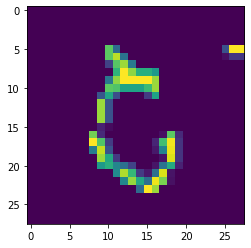

In [99]:
plt.imshow(test_images[IDX].reshape(28,28)), sample_submission.iloc[IDX]

In [100]:
test_classifier (model, nn.NLLLoss(reduction="sum"), device,  digloader)


Test set: Average loss: 0.0938, Accuracy: 9968/10240 (97%)



(0.09378398158587516, 97.34375)

In [101]:
import skorch


In [ ]:

skorch.torch_version

In [ ]:
import seaborn as sns

In [ ]:
sns.countplot(dig_mnist_data.label)

In [169]:
from torchsummary import summary

In [170]:
model

VGGNet(
  (vgg): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): Re

In [171]:
 torch.cuda.empty_cache() 

In [172]:
summa

NameError: name 'summa' is not defined

In [176]:
summary(model,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [52]:
class GlobalAvgPool(nn.Module):
    def __init__(self):
        super(GlobalAvgPool, self).__init__()
    def forward(self, x):
        return x.view(*(x.shape[:-2]),-1).mean(-1)

In [75]:
gb = GlobalAvgPool()
gb2 = nn.AvgPool2d(112)

In [57]:
from PIL import Image

In [88]:
img = Image.open("../princess.jpg")

In [64]:
txf = transforms.Compose([transforms.RandomCrop(224),transforms.ToTensor()])

In [66]:
img = txf(img)

In [67]:
gb(img)

tensor([0.4064, 0.2739, 0.1479])

In [78]:
gb2(img)

tensor([[[0.2882, 0.5871],
         [0.2448, 0.5053]],

        [[0.2104, 0.3233],
         [0.2347, 0.3271]],

        [[0.1793, 0.0547],
         [0.1918, 0.1658]]])

In [80]:
lm = transforms.Lambda (lambda image : torch.stack[img, img])

In [86]:
c5 = transforms.FiveCrop(200)

In [89]:
c5(img)

(<PIL.Image.Image image mode=RGB size=200x200 at 0x7F503485AF90>,
 <PIL.Image.Image image mode=RGB size=200x200 at 0x7F5034698810>,
 <PIL.Image.Image image mode=RGB size=200x200 at 0x7F5034801B10>,
 <PIL.Image.Image image mode=RGB size=200x200 at 0x7F502E9AE810>,
 <PIL.Image.Image image mode=RGB size=200x200 at 0x7F5034801190>)

In [95]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [104]:
EPOCHS = 5
PRINT_INTERVAL = 100


model = VGGNet(VGG13, 1, 10).to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000050)
scheduler = StepLR(optimizer,step_size=EPOCHS//5, gamma=0.1)
# early_stopping = EarlyStopping(track="max",patience=15, verbose=True, delta=0.00001>)


for epoch in range(1, EPOCHS+ 1):
    curT = time.time()
    print("Epoch: {} Learning Rate:  {:0.4f}".format(epoch, scheduler.get_lr()[0]))
    train_classifier(model, optimizer, LabelSmoothingLoss(10, 0.2), epoch, trainloader, device, print_interval=100)
    val_loss, val_acc = test_classifier(model,LabelSmoothingLoss(10,0.2), device, validloader)
    print("Time Taken: {}\n\n".format(time.time()-curT))
    scheduler.step()
#     early_stopping(val_acc, model)
    
#     if early_stopping.early_stop:
#         break

torch.save(model.state_dict(), "model_"+str(EPOCHS)+".pt")

Epoch: 1 Learning Rate:  0.0001
Train Epoch: 1 [0/49168 (0.000%)]	Loss: 2.3017619
Train Epoch: 1 [12800/49168 (25.974%)]	Loss: 1.5358887
Train Epoch: 1 [25600/49168 (51.948%)]	Loss: 1.1347406
Train Epoch: 1 [38400/49168 (77.922%)]	Loss: 1.0622814
Train Set: Average loss: 1.4052, Accuracy: 35626/49168 (72%)

Test set: Average loss: 0.0087, Accuracy: 19656/21072 (93%)

Time Taken: 28.530112266540527


Epoch: 2 Learning Rate:  0.0000
Train Epoch: 2 [0/49168 (0.000%)]	Loss: 1.0517864
Train Epoch: 2 [12800/49168 (25.974%)]	Loss: 1.0047278
Train Epoch: 2 [25600/49168 (51.948%)]	Loss: 1.0073650
Train Epoch: 2 [38400/49168 (77.922%)]	Loss: 0.9896420
Train Set: Average loss: 1.0186, Accuracy: 47582/49168 (97%)

Test set: Average loss: 0.0079, Accuracy: 20344/21072 (97%)

Time Taken: 28.80072331428528


Epoch: 3 Learning Rate:  0.0000
Train Epoch: 3 [0/49168 (0.000%)]	Loss: 0.9866614
Train Epoch: 3 [12800/49168 (25.974%)]	Loss: 1.0206035
Train Epoch: 3 [25600/49168 (51.948%)]	Loss: 0.9927338
Tra

In [2]:
nn.CrossEntropyLoss()

CrossEntropyLoss()